# Table of Contents
1. [EDA](#eda)
   1. [Data Transformations](#transform)
   2. [Outliers](#outlier)
   3. [Balance of Response](#balance)
2. [Fitting Distributions on Predictors](#distributions)
3. [Feature Evalution of Importance](#feature_selection)
    1. [LASSO](#lasso)
    2. [VIF](#vif)
    3. [Significance Test](#z_test)
4. [Model Fitting](#model)
   1. [Supervised](#sup)
      1. [Model Fit on all Available Features](#initial)
      2. [Model Fit Using Engineered and Optimal VIF Features](#better)
      3. [PCA](#pca)
   2. [Unsupervised](#unsup)
      1. [K-Mean](#k-means)
      2. [Mixture Model](#mix)
   3. [Model Conclusion](#model_conclusion) 
5. [Simulating New Data](#sim)
   1. [Kernel Density Estimates on Individual Features](#kde)

In [464]:
import pandas as pd
import altair as alt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, binom, poisson, gaussian_kde, gamma, weibull_min, lognorm
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.gam.api as smg
from sklearn.decomposition import PCA
from scipy.stats import expon
from scipy import stats
import math
np.random.seed(123)

<a id="eda"></a>
# EDA

### Data Processing and Analysis

<a id="transform"></a>
##### Data Transformations

In [308]:
data = pd.read_csv('Customer Churn.csv')

# changing status column from 1: Active, 2: In-Active to 0 and 1
data['Status'] = data['Status'] - 1

# changing Tariff Plan from 1: Pay as You Go, 2: Contractual to 0 and 1
data['Tariff Plan'] = data['Tariff Plan'] - 1

# changing Status column name to Inactivity to represent 0: False (active) and 1: True (inactive)
# changing Tariff Plan column name to Pay On Contract to represent 0: False (pay-as-you-go), 1: True (Contractual)
# Renaming other columns to make them consistent - removing 2 space between words, upper casing subsequent words
data.rename(columns={'Tariff Plan':'Pay On Contract','Status': 'Inactivity', 'Call  Failure':'Call Failure', 
                     'Subscription  Length':'Subscription Length', 
                     'Charge  Amount':'Charge Amount', 'Frequency of use':'Frequency of Use'}, inplace=True)

# Caluclating the call failure rate and adding it as a column 
data['Call Failure Rate'] = data['Call Failure'] / data['Frequency of Use']
data

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Churn,Call Failure Rate
0,8,0,38,0,4370,71,5,17,3,0,0,30,197.640,0,0.112676
1,0,0,39,0,318,5,7,4,2,0,1,25,46.035,0,0.000000
2,10,0,37,0,2453,60,359,24,3,0,0,30,1536.520,0,0.166667
3,10,0,38,0,4198,66,1,35,1,0,0,15,240.020,0,0.151515
4,3,0,38,0,2393,58,2,33,1,0,0,15,145.805,0,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,1,0,25,721.980,0,0.142857
3146,17,0,17,1,9237,177,80,42,5,0,0,55,261.210,0,0.096045
3147,13,0,18,4,3157,51,38,21,3,0,0,30,280.320,0,0.254902
3148,7,0,11,2,4695,46,222,12,3,0,0,30,1077.640,0,0.152174


##### Null Values

In [309]:
data.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Churn,Call Failure Rate
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,2996.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,0.077778,0.248254,30.998413,470.972916,0.157143,0.144741
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993,0.170858
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,0.000000,0.000000,25.000000,113.801250,0.000000,0.034160
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,0.000000,0.000000,30.000000,228.480000,0.000000,0.102753
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,0.000000,0.000000,30.000000,788.388750,0.000000,0.195122
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,1.000000,1.000000,55.000000,2165.280000,1.000000,3.500000


In [310]:
print(data.info())

data['Call Failure Rate'].isnull().sum()
data[data.isnull().any(axis=1)]
data[(data['Call Failure'] == 0) & (data['Frequency of Use']==0)] # look at rows for Call Failure is NaN
data[data['Call Failure Rate']==0] # Compare it to rows where Call Failure rate is actually 0
# Don't want to remove the rows where Call Failure is NaN because there could be some analysis done on this set it to the mean of the column

mean_cfr = data['Call Failure Rate'].mean()
data['Call Failure Rate'] = data['Call Failure Rate'].fillna(value=mean_cfr)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of Use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Pay On Contract          3150 non-null   int64  
 10  Inactivity               3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
 14  Call Failure Rate       

#### Re-ordering columns to have response at the end

In [311]:
data = data[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Churn']]

<a id="outlier"></a>
### Outliers

In [312]:
graph = []
for i in data.columns:
    chart = alt.Chart(data).mark_boxplot().encode(
        x=alt.X(f'{i}'), 
    )
    graph.append(chart)

alt.vconcat(*graph)

alt.VConcatChart(...)

<a id="balance"></a>
### Balance of Churn

In [313]:
chart = alt.Chart(data).mark_bar().encode(
    x=alt.X('Churn'),
    y=alt.Y('count()'))

chart

alt.Chart(...)

<a id="distributions"></a>
# Fitting distributions to Predictor/Features

In [314]:
data.columns

Index(['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Churn'],
      dtype='object')

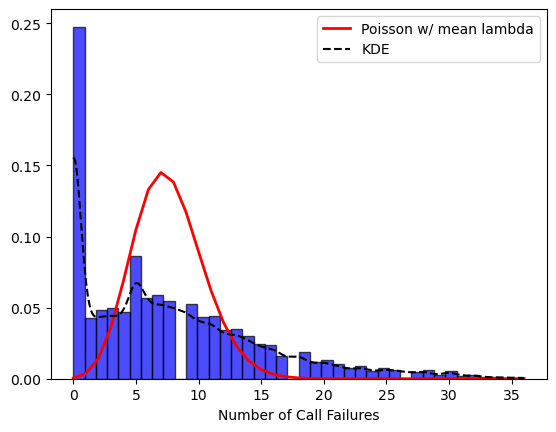

In [435]:
# Number of call failures - Poisson
plt.hist(data['Call Failure'], bins=40, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_call_failure = KernelDensity(bandwidth=0.6)
kde_call_failure.fit(data['Call Failure'].values.reshape(-1,1))
x = np.linspace(data['Call Failure'].min(), data['Call Failure'].max(), 1000).reshape(-1,1)


lambda_estimate = data['Call Failure'].mean()
max_call_failures = data['Call Failure'].max()
x_p = np.arange(0, max_call_failures+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')
plt.plot(x, np.exp(kde_call_failure.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Number of Call Failures')
plt.legend()
plt.show()

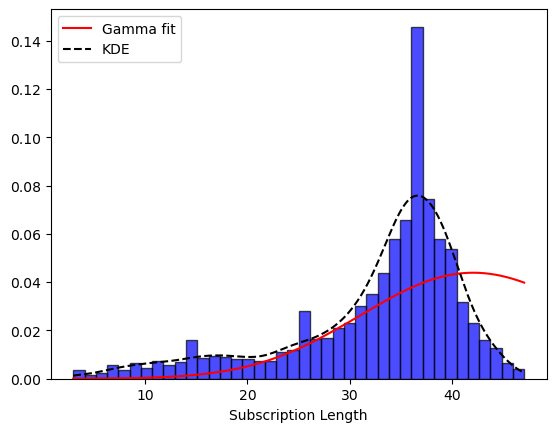

In [316]:
# Number of months for a subscription - should be something else...not poisson 
# because this isn't over some time interval unlike call failures which is # of call failuers over the 9-month period
# maybe Gamma works - time until they leave/subscription ends
plt.hist(data['Subscription Length'], bins=40, density=True, alpha=0.7, color='blue', edgecolor='black')

a, loc, scale = gamma.fit(data['Subscription Length'])

x_f = np.linspace(data['Subscription Length'].min(), data['Subscription Length'].max(), 1000)
fitted_pdf = gamma.pdf(x, a, loc, scale)

kde_sub_length = KernelDensity(bandwidth=1.5)
kde_sub_length.fit(data['Subscription Length'].values.reshape(-1,1))
x = np.linspace(data['Subscription Length'].min(), data['Subscription Length'].max(), 1000).reshape(-1,1)

plt.plot(x_f, fitted_pdf, 'r', label='Gamma fit')
plt.plot(x, np.exp(kde_sub_length.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Subscription Length')
plt.legend()
plt.show()

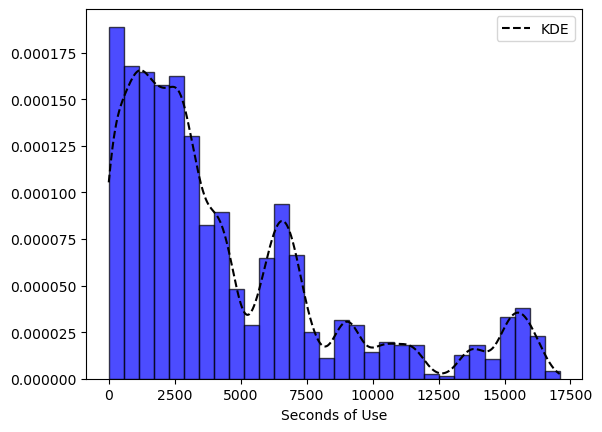

In [317]:
# Time of Use
plt.hist(data['Seconds of Use'], bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_sec_of_use = KernelDensity(bandwidth=350)
kde_sec_of_use.fit(data['Seconds of Use'].values.reshape(-1,1))
x = np.linspace(data['Seconds of Use'].min(), data['Seconds of Use'].max(), 1000).reshape(-1,1)


plt.plot(x, np.exp(kde_sec_of_use.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Seconds of Use')
plt.legend()
plt.show()

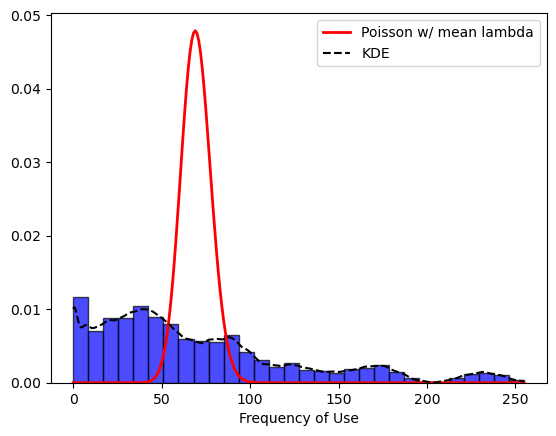

In [318]:
# Number of Calls - Poisson
plt.hist(data['Frequency of Use'], bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_freq_of_use = KernelDensity(bandwidth=2.3)
kde_freq_of_use.fit(data['Frequency of Use'].values.reshape(-1,1))
x = np.linspace(data['Frequency of Use'].min(), data['Frequency of Use'].max(), 1000).reshape(-1,1)

lambda_estimate = data['Frequency of Use'].mean()
max = data['Frequency of Use'].max()
x_p = np.arange(0, max+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')
plt.plot(x, np.exp(kde_freq_of_use.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Frequency of Use')
plt.legend()
plt.show()

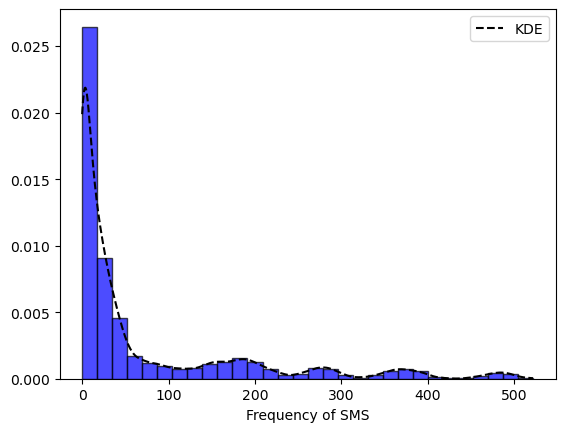

In [319]:
# Number of SMS - Poisson
plt.hist(data['Frequency of SMS'], bins=30, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_freq_of_sms = KernelDensity(bandwidth=6)
kde_freq_of_sms.fit(data['Frequency of SMS'].values.reshape(-1,1))
x = np.linspace(data['Frequency of SMS'].min(), data['Frequency of SMS'].max(), 1000).reshape(-1,1)


plt.plot(x, np.exp(kde_freq_of_sms.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Frequency of SMS')
plt.legend()
plt.show()

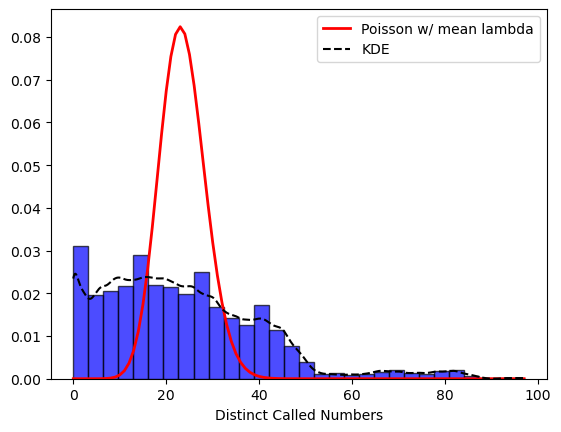

In [320]:
plt.hist(data['Distinct Called Numbers'], bins=30, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_distinct_num_called = KernelDensity(bandwidth=1)
kde_distinct_num_called.fit(data['Distinct Called Numbers'].values.reshape(-1,1))
x = np.linspace(data['Distinct Called Numbers'].min(), data['Distinct Called Numbers'].max(), 1000).reshape(-1,1)

lambda_estimate = data['Distinct Called Numbers'].mean()
max = data['Distinct Called Numbers'].max()
x_p = np.arange(0, max+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')

plt.plot(x, np.exp(kde_distinct_num_called.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Distinct Called Numbers')
plt.legend()
plt.show()

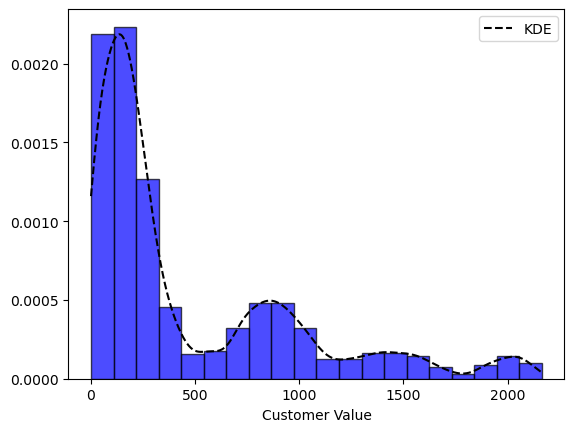

In [321]:
# total customer value - lognormal or exponential maybe
plt.hist(data['Customer Value'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_cust_value = KernelDensity(bandwidth=50)
kde_cust_value.fit(data['Customer Value'].values.reshape(-1,1))
x = np.linspace(data['Customer Value'].min(), data['Customer Value'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_cust_value.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Customer Value')
plt.legend()
plt.show()

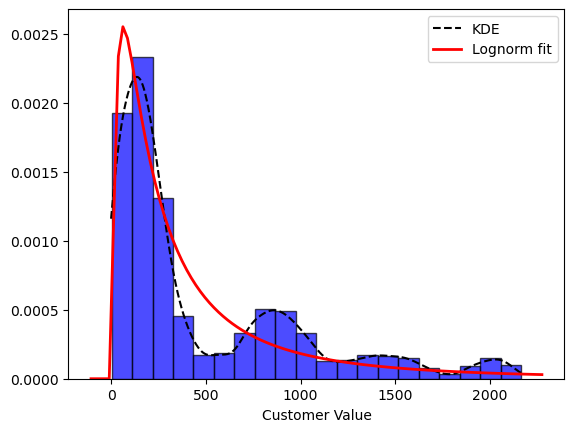

In [322]:
# total customer value - lognormal or exponential maybe
plt.hist(data[data['Customer Value']>0]['Customer Value'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

fit = lognorm.fit(data[data['Customer Value']>0]['Customer Value'], floc=0)
xmin, xmax = plt.xlim()
x_log = np.linspace(xmin, xmax, 100)
lognorm_pdf = lognorm.pdf(x_log, *fit)


kde_cust_value = KernelDensity(bandwidth=50)
kde_cust_value.fit(data['Customer Value'].values.reshape(-1,1))
x = np.linspace(data['Customer Value'].min(), data['Customer Value'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_cust_value.score_samples(x)), label='KDE', color='black', linestyle='--')

plt.plot(x_log, lognorm_pdf, 'r', linewidth=2, label='Lognorm fit')
plt.legend()
plt.xlabel('Customer Value')
plt.show()

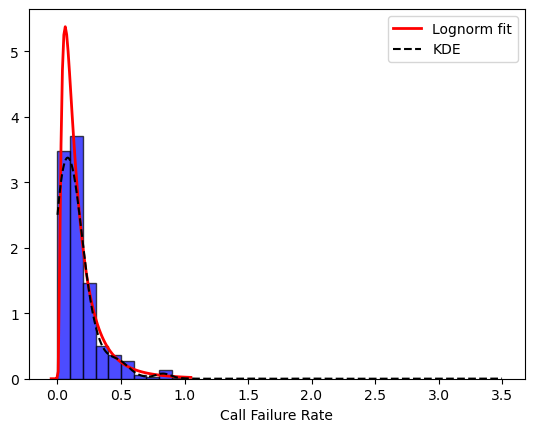

In [323]:
# call failure rate - lognormal or exponential
plt.hist(data[data['Call Failure Rate'] > 0]['Call Failure Rate'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], density=True, alpha=0.7, 
         color='blue', edgecolor='black')

fit = lognorm.fit(data[data['Call Failure Rate']>0]['Call Failure Rate'], floc=0)
xmin, xmax = plt.xlim()
x_log = np.linspace(xmin, xmax, 100)
lognorm_pdf = lognorm.pdf(x_log, *fit)


kde_call_fail_rate = KernelDensity(bandwidth=0.06)
kde_call_fail_rate.fit(data['Call Failure Rate'].values.reshape(-1,1))
x = np.linspace(data['Call Failure Rate'].min(), data['Call Failure Rate'].max(), 1000).reshape(-1,1)

plt.plot(x_log, lognorm_pdf, 'r', linewidth=2, label='Lognorm fit')
plt.plot(x, np.exp(kde_call_fail_rate.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.legend()
plt.xlabel('Call Failure Rate')
plt.show()

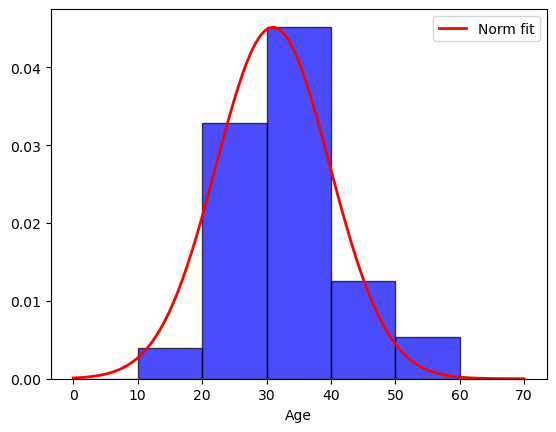

In [324]:
norm_fit = norm.fit(data['Age'])
x = np.linspace(0, 70, 100)
norm_pdf = norm.pdf(x, *norm_fit)

plt.hist(data['Age'], bins=[0,10,20,30,40,50,60,70], density=True, alpha=0.7, color='blue', edgecolor='black')
# Adding labels and title
plt.xlabel('Age')
plt.plot(x, norm_pdf, 'r', linewidth=2, label='Norm fit')

# Display the plot
plt.legend()
plt.show()

In [325]:
print(data[data['Age Group']==1]['Age'].value_counts())

print(data[data['Age Group']==2]['Age'].value_counts())

print(data[data['Age Group']==3]['Age'].value_counts())

print(data[data['Age Group']==4]['Age'].value_counts())

print(data[data['Age Group']==5]['Age'].value_counts())

Age
15    123
Name: count, dtype: int64
Age
25    1037
Name: count, dtype: int64
Age
30    1425
Name: count, dtype: int64
Age
45    395
Name: count, dtype: int64
Age
55    170
Name: count, dtype: int64


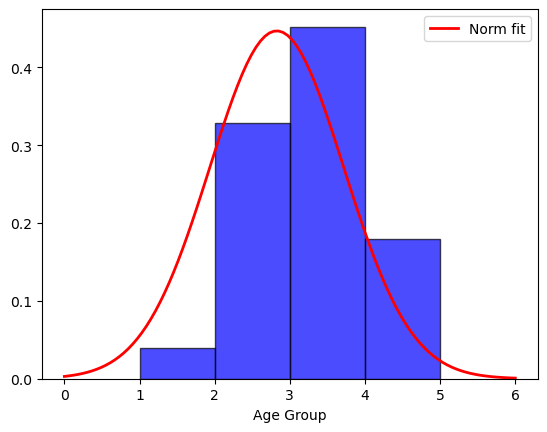

In [326]:
plt.hist(data['Age Group'], bins=[1, 2, 3, 4, 5], density=True, alpha=0.7, color='blue', edgecolor='black')

norm_age_group = norm.fit(data['Age Group'])
x = np.linspace(0, 6, 100)
norm_pdf = norm.pdf(x, *norm_age_group)

plt.plot(x, norm_pdf, 'r', linewidth=2, label='Norm fit')

plt.xlabel('Age Group')
# Display the plot
plt.legend()
plt.show()

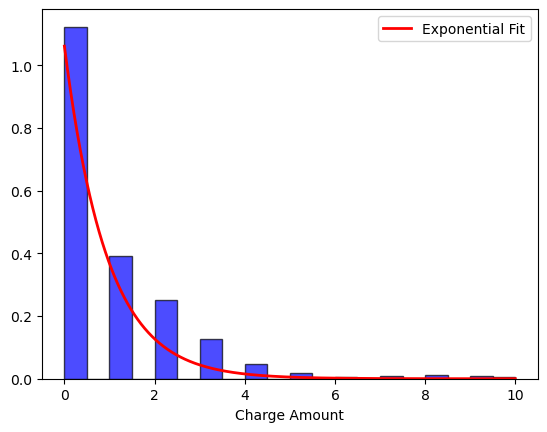

In [327]:
plt.hist(data['Charge Amount'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

loc_charge_amount, scale_charge_amount = expon.fit(data['Charge Amount'])
x = np.linspace(0, np.max(data['Charge Amount']), 1000)
y = expon.pdf(x, loc=loc_charge_amount, scale=scale_charge_amount)
plt.plot(x, y, 'r-', linewidth=2, label='Exponential Fit')

plt.legend()
plt.xlabel('Charge Amount')
plt.show()

In [328]:
p_no_complain = data['Complains'].value_counts().values[0]/data.shape[0]
print(p_no_complain)

p_no_pay_on_contract = data['Pay On Contract'].value_counts().values[0]/data.shape[0]
print(p_no_pay_on_contract)

p_active = data['Inactivity'].value_counts().values[0]/data.shape[0]
print(p_active)

0.9234920634920635
0.9222222222222223
0.7517460317460317


In [329]:
data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Call Failure Rate,Churn
0,8,0,38,0,4370,71,5,17,3,0,0,30,197.640,0.112676,0
1,0,0,39,0,318,5,7,4,2,0,1,25,46.035,0.000000,0
2,10,0,37,0,2453,60,359,24,3,0,0,30,1536.520,0.166667,0
3,10,0,38,0,4198,66,1,35,1,0,0,15,240.020,0.151515,0
4,3,0,38,0,2393,58,2,33,1,0,0,15,145.805,0.051724,0


<a id="feature_selection"></a>
# Feature Selection

In [330]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), data['Churn'], test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

<a id="lasso"></a>
### Lasso

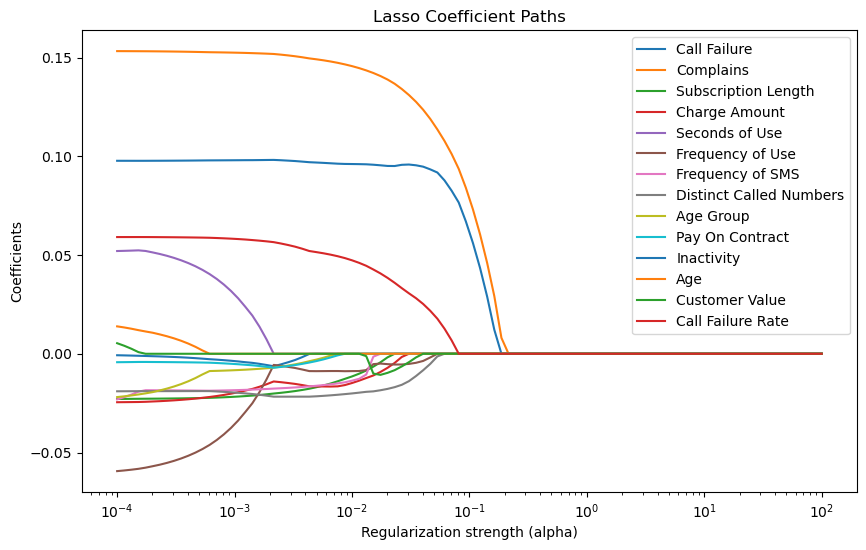

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Call Failure Rate
0,-0.0,0.143488,-0.008482,-0.012295,-0.0,-0.008268,-0.010525,-0.019271,-0.0,-0.0,0.095938,-0.0,-0.001188,0.044549
1,-0.0,0.142172,-0.006522,-0.010987,-0.0,-0.005244,-0.001462,-0.019035,-0.0,-0.0,0.095723,-0.0,-0.010018,0.042670
2,-0.0,0.140632,-0.004321,-0.009214,-0.0,-0.004962,-0.000000,-0.018476,-0.0,-0.0,0.095432,-0.0,-0.010685,0.040686
3,-0.0,0.138857,-0.001798,-0.007111,-0.0,-0.005254,-0.000000,-0.017783,-0.0,-0.0,0.095102,-0.0,-0.009662,0.038428
4,-0.0,0.136714,-0.000000,-0.004618,-0.0,-0.005448,-0.000000,-0.016901,-0.0,-0.0,0.095068,-0.0,-0.008303,0.035924
5,-0.0,0.134057,-0.000000,-0.001615,-0.0,-0.005421,-0.000000,-0.015714,-0.0,-0.0,0.095675,-0.0,-0.006396,0.033219
6,-0.0,0.131027,-0.000000,-0.000000,-0.0,-0.005139,-0.000000,-0.013874,-0.0,-0.0,0.095822,-0.0,-0.004256,0.030614
7,-0.0,0.127569,-0.000000,-0.000000,-0.0,-0.004572,-0.000000,-0.011273,-0.0,-0.0,0.095433,-0.0,-0.001845,0.028130
8,-0.0,0.123571,-0.000000,-0.000000,-0.0,-0.003635,-0.000000,-0.008342,-0.0,-0.0,0.094738,-0.0,-0.000000,0.025219
9,-0.0,0.118926,-0.000000,-0.000000,-0.0,-0.001870,-0.000000,-0.005131,-0.0,-0.0,0.093370,-0.0,-0.000000,0.021750


In [331]:
alphas = np.logspace(-4, 2, 100)
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient Paths')
plt.legend(labels=x_train.drop(columns=[]).columns) 
plt.show()
a = pd.DataFrame(coefs[35:50], columns=x_train.drop(columns=[]).columns)
a

<a id="vif"></a>
### Variance Inflation Factor

In [332]:
endog = y_train
exog = x_train
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score # age and age group probably has correlation so pick age group to ignore potential decision boundries in-between ages

{'const': 44.83710304703584,
 'Call Failure': 4.429199493783642,
 'Complains': 1.1744615569306371,
 'Subscription Length': 1.183082707070743,
 'Charge Amount': 3.2192882448235016,
 'Seconds of Use': 22.58681394358586,
 'Frequency of Use': 19.653137657423855,
 'Frequency of SMS': 45.22335696920421,
 'Distinct Called Numbers': 2.5314696245029635,
 'Age Group': 14.124770835372647,
 'Pay On Contract': 1.5795710426487244,
 'Inactivity': 1.8772760777654234,
 'Age': 14.827496029162871,
 'Customer Value': 57.745873379079946,
 'Call Failure Rate': 2.0705998185200087}

In [333]:
endog = y_train
exog = x_train.drop(columns=['Age'])
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score # frequency of use correlated with seconds of use && frequency of sms correlated with customer value perhaps

{'const': 38.009091703183636,
 'Call Failure': 4.3882139525683534,
 'Complains': 1.1689801046938988,
 'Subscription Length': 1.1814917740902615,
 'Charge Amount': 3.21856879094854,
 'Seconds of Use': 22.1167241109934,
 'Frequency of Use': 19.621935957372614,
 'Frequency of SMS': 43.39743250598221,
 'Distinct Called Numbers': 2.4474467638152277,
 'Age Group': 2.102776227827874,
 'Pay On Contract': 1.5452604628039524,
 'Inactivity': 1.8764918967944704,
 'Customer Value': 54.66863387224357,
 'Call Failure Rate': 2.060373280727997}

Frequency of use correlated with Seconds of use -> then make a new feature which is average seconds per call   
1. Seconds of Use (numerical): total seconds of calls over 9 month period2. Frequency of use (numerical): total number of calls over 9 month period

In [334]:
data['Average Sec per Call'] = data['Seconds of Use']/data['Frequency of Use']
mean_avg_sec_per_call = data['Average Sec per Call'].mean()
data.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)

data = data[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Average Sec per Call',
       'Churn']] # re-ordering to have response column at the end

kde_average_sec_per_call = KernelDensity(bandwidth=0.06)
kde_average_sec_per_call.fit(data['Average Sec per Call'].values.reshape(-1,1))

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), data['Churn'], test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

endog = y_train
exog = x_train.drop(columns=['Age', 'Seconds of Use'])
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

/tmp/ipykernel_229402/937085608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Average Sec per Call'] = data['Seconds of Use']/data['Frequency of Use']
/tmp/ipykernel_229402/937085608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)


{'const': 39.20283562672715,
 'Call Failure': 4.086536015174128,
 'Complains': 1.1681261617199794,
 'Subscription Length': 1.2007329417796784,
 'Charge Amount': 2.5115031972835373,
 'Frequency of Use': 8.4471045836983,
 'Frequency of SMS': 31.439075706072853,
 'Distinct Called Numbers': 2.4382901969193846,
 'Age Group': 1.9463527705070947,
 'Pay On Contract': 1.3612699235491506,
 'Inactivity': 1.861859255156008,
 'Customer Value': 39.415047771433436,
 'Call Failure Rate': 2.0945891860158627,
 'Average Sec per Call': 1.328319956586573}

Between Customer value and Frequency of SMS, remove frequency of sms because based on Lasso it goes to 0 before Customer Value

In [335]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), data['Churn'], test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

endog = y_train
exog = x_train.drop(columns=['Age', 'Seconds of Use', 'Frequency of SMS'])
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 37.880309735635265,
 'Call Failure': 3.8923188894391303,
 'Complains': 1.163422724191341,
 'Subscription Length': 1.1935701504928693,
 'Charge Amount': 2.475807443102864,
 'Frequency of Use': 3.6206051385206046,
 'Distinct Called Numbers': 2.4348051227084273,
 'Age Group': 1.2616577590366604,
 'Pay On Contract': 1.3601690990678723,
 'Inactivity': 1.856999985162553,
 'Customer Value': 1.4810774778346314,
 'Call Failure Rate': 2.070248351974922,
 'Average Sec per Call': 1.2107104534181046}

From the above, all VIF values below 10, except for the const. Therefore, multicollinearity significantly reduced. 

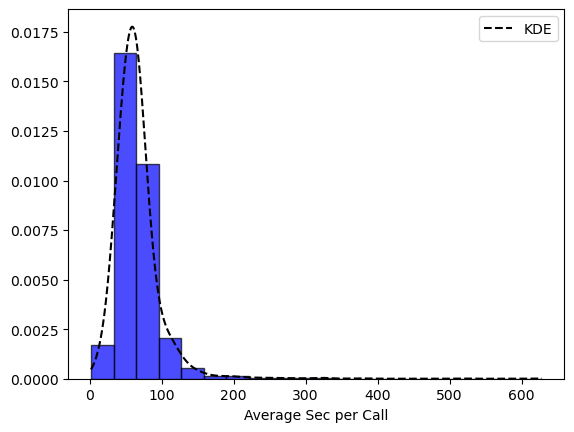

In [336]:
plt.hist(data['Average Sec per Call'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_average_sec_per_call = KernelDensity(bandwidth=12)
kde_average_sec_per_call.fit(data['Average Sec per Call'].values.reshape(-1,1))
x = np.linspace(data['Average Sec per Call'].min(), data['Average Sec per Call'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_average_sec_per_call.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Average Sec per Call')
plt.legend()
plt.show()

<a id="z_test"></a>
### Comparing marginal distributions of each feature between churn and not churned

In [337]:
N = len(data.columns)-1
z_score = {}
for i in range(N):
    mu_0, sigma_0 = norm.fit(data[data['Churn'] == 0].iloc[:,[i,15]])
    mu_1, sigma_1 = norm.fit(data[data['Churn'] == 1].iloc[:,[i,15]])
    z = (mu_0-mu_1) / np.sqrt(sigma_0**2 + sigma_1**2)
    z_score[data.columns[i]] = z
z_score

{'Call Failure': -0.04549970658524965,
 'Complains': -1.4909644129411967,
 'Subscription Length': -0.004803669460067019,
 'Charge Amount': -0.05596636778159771,
 'Seconds of Use': 0.4134023111059113,
 'Frequency of Use': 0.3832342546417229,
 'Frequency of SMS': 0.3506855753343583,
 'Distinct Called Numbers': 0.30245884315673255,
 'Age Group': -0.2581308989667535,
 'Pay On Contract': -0.8518335480541744,
 'Inactivity': -1.8667652346109505,
 'Age': -0.01243243611162162,
 'Customer Value': 0.4293941629761614,
 'Call Failure Rate': -1.3498067472208841,
 'Average Sec per Call': -0.003159812627362492}

Columns which are likely to fail significane test at predicting churn based on z-score:
1. Customer Value
2. Seconds of Use
3. Frequency of SMS
5. Frequency of Use
6. Distinct Called Numbers

**Note:** Assumes normal distribution, which may be true for large enough sample size, however, this data set has less than 4000 rows, of which only about 500 are for customers who have churned (desired class to predict in response - very unbalanced). As such, these scores may be off. 

<a id="model"></a>
# Model Fitting

<a id="sup"></a>
## Supervised Methods

<a id="initial"></a>
### Fitting models with **all features** - engineered + original
**Note:** These models will be referred to as the **"Original Models"**     
Settings:
1. using all available features (engineered plus original)
2. accounting for imbalanced classes in response
3. cross-validation scored on 'roc_auc' for binary response

In [338]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


#### Cross-Validation

In [339]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}

scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']
cv_scores_mean = {}
cv_scores_stdv = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_scaled, y_train, cv=10, scoring=scoring)
    cv_scores_mean[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean = pd.DataFrame(cv_scores_mean).T
print(cv_scores_df_mean)
cv_scores_df_stdv = pd.DataFrame(cv_scores_stdv).T
print(cv_scores_df_stdv)

           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.646139  0.939452           0.866188           0.597396
svc  0.727741  0.964214           0.899661           0.688087
rf   0.857282  0.984297           0.903645           0.835961
btc  0.879958  0.987174           0.932020           0.859361
           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.028227  0.013806           0.024508           0.036700
svc  0.037872  0.008372           0.022826           0.044850
rf   0.030872  0.006941           0.027580           0.033639
btc  0.024171  0.005133           0.018652           0.028409


#### Test Set

In [340]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(x_train_scaled, y_train)

svc = SVC(probability=True, class_weight='balanced', random_state=42)
svc.fit(x_train_scaled, y_train)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(x_train_scaled, y_train)

lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
lgbm.fit(x_train_scaled, y_train)

models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}
model_scores = {}
for model in models:
    y_pred = models[model].predict(x_test_scaled)
    y_pred_prob = models[model].predict_proba(x_test_scaled)[:, 1]
    f1 = f1_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    model_scores[model] = [f1, ll, roc_auc, cm]
model_scores

{'log': [0.6486486486486486,
  0.35638027686500995,
  0.9221011546592942,
  array([[538, 107],
         [ 23, 120]])],
 'svc': [0.7542857142857142,
  0.20009811788950665,
  0.9567246706781591,
  array([[570,  75],
         [ 11, 132]])],
 'rf': [0.8394160583941606,
  0.1420412857312732,
  0.9824849569035616,
  array([[629,  16],
         [ 28, 115]])],
 'btc': [0.8551724137931034,
  0.1390860338507431,
  0.9845557543231962,
  array([[622,  23],
         [ 19, 124]])]}

<a id="better"></a>
### Fitting models with **sub-set of features** - engineered + VIF optimal
**Note:** These models will be referred to as the **"Subset Models"**     
Settings:
1. using engineered features plus features with minimal multi-collinearity from above VIF analysis
2. accounting for imbalanced classes in response
3. cross-validation scored on 'roc_auc' for binary response

In [341]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use', 'Frequency of SMS']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


#### Cross-validation

In [342]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}
scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']

cv_scores_mean = {}
cv_scores_stdv = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_scaled, y_train, cv=10, scoring=scoring)
    cv_scores_mean[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean = pd.DataFrame(cv_scores_mean).T
print(cv_scores_df_mean)
cv_scores_df_stdv = pd.DataFrame(cv_scores_stdv).T
print(cv_scores_df_stdv)

           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.638434  0.938988           0.860659           0.587713
svc  0.735335  0.964515           0.900969           0.695980
rf   0.849433  0.981516           0.898902           0.827203
btc  0.876196  0.987551           0.931234           0.854967
           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.031621  0.013988           0.028251           0.041969
svc  0.035343  0.009357           0.022794           0.042409
rf   0.028559  0.008907           0.028343           0.029356
btc  0.035852  0.005064           0.024748           0.042375


#### Test Set

In [343]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(x_train_scaled, y_train)

svc = SVC(probability=True, class_weight='balanced', random_state=42)
svc.fit(x_train_scaled, y_train)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(x_train_scaled, y_train)

lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
lgbm.fit(x_train_scaled, y_train)

models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}
model_scores = {}
for name, model in models.items():
    y_pred = model.predict(x_test_scaled)
    y_pred_prob = model.predict_proba(x_test_scaled)[:, 1]
    f1 = f1_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    model_scores[name] = [f1, ll, roc_auc, cm]
model_scores

{'log': [0.6558265582655827,
  0.3597978092718982,
  0.9210386512712094,
  array([[540, 105],
         [ 22, 121]])],
 'svc': [0.760233918128655,
  0.19820865810460994,
  0.956318100504147,
  array([[576,  69],
         [ 13, 130]])],
 'rf': [0.8436363636363636,
  0.14244127524886643,
  0.9818236027538353,
  array([[629,  16],
         [ 27, 116]])],
 'btc': [0.8698630136986302,
  0.127456451950007,
  0.986837968233317,
  array([[623,  22],
         [ 16, 127]])]}

<a id="pca"></a>
### PCA
**Note:** Initially only the response column, 'churn', was dropped, however, after trying the same set of columns which gave improved results under Boosting Tree Classifier model - similar improvments were noticed here, and so decided to go with the engineered and VIF optimal columns.
**Note:** Dropping Age Group because its essentially the same as Age and don't want to resample 2 of the same things.

In [360]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [358]:
exog = pd.DataFrame(x_test_pca, columns=x_train.columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 1.010311476165945,
 'Call Failure': 1.0200740862626856,
 'Complains': 1.0566213808209761,
 'Subscription Length': 1.0653965997992783,
 'Charge Amount': 1.013909023162837,
 'Seconds of Use': 1.0128737250298196,
 'Frequency of Use': 1.0486181764553921,
 'Frequency of SMS': 1.0602567830651493,
 'Distinct Called Numbers': 1.069732215047024,
 'Age Group': 1.027743735337985,
 'Pay On Contract': 1.034404851333347,
 'Inactivity': 1.1003411736971036,
 'Customer Value': 1.1644068660882818,
 'Call Failure Rate': 1.04829600582775,
 'Average Sec per Call': 1.0236644108427335}

#### Cross-validation

In [346]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}

scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']
cv_scores_mean = {}
cv_scores_stdv = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_pca, y_train, cv=10, scoring=scoring)
    cv_scores_mean[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean = pd.DataFrame(cv_scores_mean).T
print(cv_scores_df_mean)
cv_scores_df_stdv = pd.DataFrame(cv_scores_stdv).T
print(cv_scores_df_stdv)

           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.644243  0.939626           0.865402           0.595264
svc  0.721619  0.963949           0.897920           0.681469
rf   0.806733  0.980703           0.865666           0.780125
btc  0.846303  0.982253           0.912051           0.819908
           f1   roc_auc  balanced_accuracy  matthews_corrcoef
log  0.030367  0.013697           0.024879           0.038954
svc  0.033403  0.008127           0.021860           0.040182
rf   0.036361  0.006934           0.027457           0.040775
btc  0.014678  0.006336           0.013786           0.017447


#### Test Set

In [347]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(x_train_pca, y_train)

svc = SVC(probability=True, class_weight='balanced', random_state=42)
svc.fit(x_train_pca, y_train)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(x_train_pca, y_train)

lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
lgbm.fit(x_train_pca, y_train)

models = {'log': logreg, 'svc': svc, 'rf': rf, 'btc': lgbm}
model_scores = {}
for name, model in models.items():
    y_pred = model.predict(x_test_pca)
    y_pred_prob = model.predict_proba(x_test_pca)[:, 1]
    f1 = f1_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    model_scores[name] = [f1, ll, roc_auc, cm]
model_scores

{'log': [0.6522911051212937,
  0.3566704171534,
  0.9220252615601453,
  array([[538, 107],
         [ 22, 121]])],
 'svc': [0.749279538904899,
  0.2024419973937615,
  0.9550170759473084,
  array([[571,  74],
         [ 13, 130]])],
 'rf': [0.8290909090909091,
  0.16043397174134186,
  0.9760340434759038,
  array([[627,  18],
         [ 29, 114]])],
 'btc': [0.8873239436619719,
  0.14409318640278032,
  0.982490377839215,
  array([[630,  15],
         [ 17, 126]])]}

<a id="unsup"></a>
## Unsupervised Methods

<a id="k-means"></a>
### K-Means

In [348]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use', 'Frequency of SMS']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [349]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=25)
kmeans.fit(x_train_scaled)
y_pred = kmeans.predict(x_test_scaled)

In [350]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[288, 357],
       [  6, 137]])

<a id="mix"></a>
### Mixture Model   
**Note:** Initially attemped with engineered and optimal VIF features, but better performance observed from using all columns including original and engineered.

In [351]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [352]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x_train_scaled)

y_pred = gmm.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm

array([[485, 160],
       [ 17, 126]])

<a id="model_conclusion"></a>
## Model Conclusion    
Based on the above analysis, right away the unsupervised models can be scrapped because the K-Means clusterings are terrible as seen from the confusion matrix which when compared to the Original and Subset models is much worse. In addition, although the Mixture Model performed very well at classifiying the Churned group, it misclassified many non-churn customers as churned - although this is not that big of a deal, the Original and Subset models performed better in comparison.   

The Subset model, specifically the Boosting Tree Classifier (subset) performed the best on the test set, however, the Boosting Tree Classifier (Original) is still very close. Taking a closer look at the cross-validated mean and variance metrics, we see both the subset and original BTC are very close and the BTC (original) even beats the subset in metrics like the balanced_accurance and matthews_corrcoef.        

Initially, the BTC subset is the favourable choice because it performed slightly better, and more importantly, the VIF of the features chosen are between 1 and 5, indicating minimal multicollinearity. This is important because when simulating new data, if independently fit KDE's are used (as is the plan in later steps), this assumes independence among the features and so using the BTC (original) model with all columns would violate that assumption because in the orignal VIF analysis a few features had VIF greater than 10.        

However, another idea would be to use PCA to remove multicollinearity and sample the independently fit KDE's and transform those values into the PCA space - which would theoritically ensure independance among the features via PCA assumptions. But, this also relies on the assumption that the covariance matrix of the sampled data is identical to the covariance matrix of the trained data (this was already tested for the train/test split and although the VIF wasn't exactly 1, it was very close and much better than the previous optimal VIF. VIF will also be tested again on the train and new sampled data to ensure this is met).      
      
If the above assumptions hold, looking at the results of the BTC (original) on PCA components, the performace on the test set is very close to the non-PCA (original) [123 correct churn vs. 124 correct churn] and slightly worse than BTC (subset). The cross-validated metrics are all very similar indicating very close performance in the long-run. Although minor improvments on PCA BTC can be gained if the subset columns are used - the cross-validated score does not change much and so we are just over-fitting on the test set which is not correct.    
    
Therefore the PCA BTC (original) model is the newly favoured model if the assumptions of covariance/multicollinearity hold for the transformed sampled data, else the BTC (subset) is the next best model where multicollinearity is minimized. 

<a id="sim"></a>
# Simulating New Data from Distributions

<a id="kde"></a>
### Independent Kernel Density Estimates 
**Note:** Using KDE's that were fit in Section 2

To use KDE's fit individually on each feature assumes no correlation between the features, however, from the VIF we know this to be false. However, under PCA assumptions, the principal components are made such that there is no correlation between the components. So if the simulated data is mapped in the PCA transformed space, as long as the covariance structure of the sampled data matched that of the trained data, there should be no correlation between the features of the sampled data in the PCA mapped space.      

**Add testing results same as VIF test was done for train/test split for PCA**

In [353]:
data.columns

Index(['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Average Sec per Call',
       'Churn'],
      dtype='object')

In [354]:
samples = []
sample = kde['Call Failure'].sample(1)[0][0]
sample
kde_sub_length.sample(1)

array([[36.76146072]])

In [472]:
kde = {
    'Call Failure': kde_call_failure,
    'Complains': p_no_complain,
    'Subscription Length': kde_sub_length ,
    'Charge Amount': [loc_charge_amount, scale_charge_amount],
    'Seconds of Use': kde_sec_of_use,
    'Frequency of Use': kde_freq_of_use, 
    'Frequency of SMS': kde_freq_of_sms,
    'Distinct Called Numbers': kde_distinct_num_called, 
    'Pay On Contract': p_no_pay_on_contract, 
    'Inactivity': p_active,
    'Age Group': norm_age_group,
    'Customer Value': kde_cust_value
}

def sample_kde_with_threshold(density, lower_bound, num_samples):
    samples = []
    while len(samples) < num_samples:
        sample = density.sample(1)[0][0]
        if sample >= lower_bound:
            samples.append(sample)
    return np.array(samples)

lower_bound = 0 
num_samples = 10000

samples = pd.DataFrame()
for feature, density in kde.items():
    if isinstance(density, KernelDensity):
        feature_samples = sample_kde_with_threshold(density, lower_bound, num_samples)
    elif feature == 'Age Group':
        feature_samples = np.random.normal(density[0], density[1], num_samples)
    elif feature in ['Complains', 'Pay On Contract', 'Inactivity']:
        feature_samples = np.random.binomial(1, p=density, size=num_samples)
    elif feature == 'Charge Amount':
        feature_samples = np.random.exponential(scale=density[1], size=num_samples) + density[0]
    else:
        feature_samples = np.full(num_samples, density)
    samples[feature] = feature_samples
samples.head()
samples.describe()


samples.loc[samples['Age Group'] <= 1.9, 'Age Group'] = 1
samples.loc[(samples['Age Group'] > 1.9) & (samples['Age Group'] <= 2.9), 'Age Group'] = 2
samples.loc[(samples['Age Group'] > 2.9) & (samples['Age Group'] <= 3.9), 'Age Group'] = 3
samples.loc[(samples['Age Group'] > 3.9) & (samples['Age Group'] <= 4.9), 'Age Group'] = 4
samples.loc[samples['Age Group'] > 4.9, 'Age Group'] = 5
samples['Age Group'] = samples['Age Group'].astype(int)
samples.loc[(samples['Charge Amount'] < 0.8), 'Charge Amount'] = 0
samples['Charge Amount'] = samples['Charge Amount'].round().astype(int)
samples.loc[(samples['Call Failure'] < 0.9), 'Call Failure'] = 0
samples['Call Failure'] = samples['Call Failure'].round().astype(int)
samples['Subscription Length'] = samples['Subscription Length'].round().astype(int)
samples['Seconds of Use'] = samples['Seconds of Use'].round().astype(int)
samples['Frequency of Use'] = samples['Frequency of Use'].round().astype(int)
samples['Frequency of SMS'] = samples['Frequency of SMS'].round().astype(int)
samples['Distinct Called Numbers'] = samples['Distinct Called Numbers'].round().astype(int)

samples.loc[samples['Call Failure'] > samples['Frequency of Use'], 'Call Failure'] = samples['Frequency of Use'] # can't have more failures than calls
samples.loc[samples['Frequency of Use']==0, 'Seconds of Use'] = 0

samples['Call Failure Rate'] = samples['Call Failure'] / samples['Frequency of Use']
mean_cfr = samples['Call Failure Rate'].mean()
samples['Call Failure Rate'] = samples['Call Failure Rate'].fillna(value=mean_cfr)

samples['Average Sec per Call'] = samples['Seconds of Use']/samples['Frequency of Use']
mean_avg_sec_per_call = samples['Average Sec per Call'].mean()
samples.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)

samples = samples[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Customer Value', 'Call Failure Rate', 'Average Sec per Call']]

samples.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Customer Value,Call Failure Rate,Average Sec per Call
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8.088700,0.921800,32.377400,0.745100,4621.021600,71.984600,84.117200,24.304500,2.456300,0.921100,0.753200,499.072297,0.227093,226.607921
std,6.927051,0.268499,8.938219,1.072866,4224.823457,56.946294,115.891203,16.980631,0.901095,0.269596,0.431171,523.417593,0.280741,837.036046
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.042156,0.000000,0.000000
25%,3.000000,1.000000,29.000000,0.000000,1540.000000,30.000000,10.000000,11.000000,2.000000,1.000000,1.000000,127.783778,0.041202,23.256409
50%,7.000000,1.000000,35.000000,0.000000,3117.000000,57.000000,28.000000,22.000000,2.000000,1.000000,1.000000,248.432311,0.116667,58.330729
75%,12.000000,1.000000,38.000000,1.000000,6540.250000,97.000000,125.000000,34.000000,3.000000,1.000000,1.000000,812.481827,0.277778,151.378057
max,36.000000,1.000000,50.000000,9.000000,17588.000000,260.000000,544.000000,99.000000,5.000000,1.000000,1.000000,2277.533491,1.000000,16841.000000


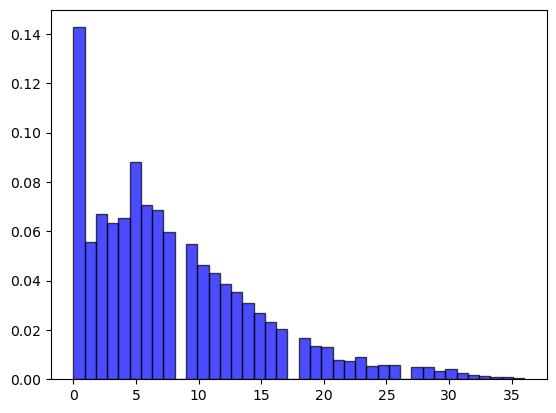

In [441]:
plt.hist(samples['Call Failure'], bins=40, alpha=0.7, density=True, color='blue', edgecolor='black')

plt.show()

In [395]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age']), 
                                                    data['Churn'], test_size=0.25, random_state=42)


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_sample_scaled = scaler.transform(samples)
x_sample_pca = pca.transform(x_sample_scaled)

exog = pd.DataFrame(x_sample_pca, columns=samples.columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 22.010846745194378,
 'Call Failure': 2.038438211863465,
 'Complains': 19.529006495641635,
 'Subscription Length': 44.12242968037894,
 'Charge Amount': 139.15365382438247,
 'Seconds of Use': 10.645826745422308,
 'Frequency of Use': 93.99393648685631,
 'Frequency of SMS': 140.63014158946592,
 'Distinct Called Numbers': 1.9863738263194044,
 'Age Group': 2.938946511948283,
 'Pay On Contract': 3.8880282038255305,
 'Inactivity': 55.30722086176051,
 'Customer Value': 24.180217434341305,
 'Call Failure Rate': 8.720197604773324,
 'Average Sec per Call': 1.0986321539542607}

In [442]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use', 'Frequency of SMS']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_sample_scaled = scaler.transform(samples.drop(columns=['Seconds of Use', 'Frequency of SMS']))

exog = pd.DataFrame(x_sample_scaled, columns=samples.drop(columns=['Seconds of Use', 'Frequency of SMS']).columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 23.022619986277654,
 'Call Failure': 1.3862641896297203,
 'Complains': 1.0021124255362235,
 'Subscription Length': 1.0007430252408926,
 'Charge Amount': 1.0008130968123838,
 'Frequency of Use': 1.544984521460374,
 'Distinct Called Numbers': 1.0009542322022822,
 'Age Group': 1.0018982163398904,
 'Pay On Contract': 1.0010605901684548,
 'Inactivity': 1.0006218343722189,
 'Customer Value': 1.0020386335303892,
 'Call Failure Rate': 2.000428473375425,
 'Average Sec per Call': 1.2489841176008847}

### Prediction

In [443]:
lgbm = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
lgbm.fit(x_train_scaled, y_train)

models = {'btc': lgbm}
model_scores = {}
for name, model in models.items():
    y_pred = model.predict(x_test_scaled)
    y_pred_prob = model.predict_proba(x_test_scaled)[:, 1]
    f1 = f1_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    model_scores[name] = [f1, ll, roc_auc, cm]
model_scores

{'btc': [0.8698630136986302,
  0.127456451950007,
  0.986837968233317,
  array([[623,  22],
         [ 16, 127]])]}

In [444]:
y_pred_sample = lgbm.predict(x_sample_scaled)
unique_values, counts = np.unique(y_pred_sample, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[3671 6329]


In [460]:
new_sample_data = samples
new_sample_data['Predict Churn'] = y_pred_sample
sample_call_failure = new_sample_data.loc[new_sample_data['Predict Churn']==1,:]['Call Failure']
m = sample_call_failure.mean()
std = sample_call_failure.std()
print(m)
print(std)
confidence_level = 0.50
ci = stats.t.interval(confidence_level, len(sample_call_failure)-1, loc=m, scale=std)
print(f"Mean: {m}")
print(f"50% CI: {ci}")

8.35503239058303
7.114527726795457
Mean: 8.35503239058303
50% CI: (3.5560805188477973, 13.153984262318264)


In [463]:
sample_call_failure_complain = new_sample_data.loc[new_sample_data['Complains']==1,:]['Call Failure']
m = sample_call_failure_complain.mean()
std = sample_call_failure_complain.std()
print(m)
print(std)
confidence_level = 0.5
ci = stats.t.interval(confidence_level, len(sample_call_failure_complain)-1, loc=m, scale=std)
print(f"Mean: {m}")
print(f"50% CI: {ci}")

8.001297297297297
6.899726517560655
Mean: 8.001297297297297
50% CI: (3.3473194565092204, 12.655275138085374)


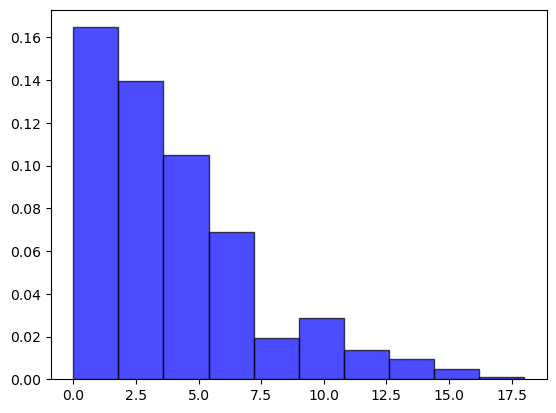

In [473]:
new_samples = samples
new_samples['Call Failure'] = new_samples['Call Failure'] / 2
new_samples['Call Failure'] = new_samples['Call Failure'].astype(int)
plt.hist(new_samples['Call Failure'], bins=10, alpha=0.7, density=True, color='blue', edgecolor='black')
plt.show()

In [474]:
x_new_sample_scaled = scaler.transform(new_samples.drop(columns=['Seconds of Use', 'Frequency of SMS']))

y_pred_sample = lgbm.predict(x_new_sample_scaled)
unique_values, counts = np.unique(y_pred_sample, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[3692 6308]
